### (Cose da sistemare)
#### - Normalizzazione, lascio spazi? Underscore.. per fare il check su nome categoria presente nel nome file
#### - Properties check lo separo in più pezzi per categoria? (classificazione, regressione, time series..)
#### - Salvare il dataframe con i dataset esternamente
#### - Test shapiro: è il migliore?
#### - Down sampling solo in fase training e non testing?
#### - RandomForest settare bene n tree
#### - Caratteristiche per le categorie.. (ovvio)
#### - Limitare numero features da iterare in dataset..?

---------------------------



### Classificazione
1. Presenza variabile che fa match con uno dei nomi categorie (label, class etc..)
2. Questa variabile che fa match, se è all'ultima posizione
3. Questa variabile che fa match, se è categorica
#### Diventa una terna di risultati binari tra le combinazioni possibili: {(1,0,0), (1,1,0), (1,0,1), (1,1,1)}

### Regressione Lineare
1. Numero assoluto di variabili numeriche
2. Proporzione di variabili numeriche sul totale di variabili
3. Numero assoluto di variabili con distribuzione normale
4. Proporzione di variabili con distribuzione normale sul totale di variabili numeriche
#### Diventa una quaterna con risultati possibili: ( [0,n], [0,1], [0,m], [0,1] ), con n = n. variabili, m = n. variabili numeriche

### NLP
1. Numero assoluto di variabili testuali
2. Proporzione di variabili testuali sul totale di variabili

### Clustering
1. Silhouette Index

### PCA
1. Numero features (dovrebbe essere più alto)
2. Numero righe

### Serie temporali
1. Presenza di variabile temporali
2. Disposizione in ordine del tempo

### Computer Vision

### ?? GAN



In [37]:
#Librerie base (servono sempre/quasi sempre)
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
#Per i json
import json


#sklearn per ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#test normalità
from scipy.stats import shapiro, kstest
pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_col')

In [2]:
import re
def normalize_word(feature):
    # Rimozione di simboli strani e sostituzione degli spazi con underscore
    new_feature = re.sub(r'[^a-zA-Z_]', '', feature)
    # Sostituisci underscore con spazio
    new_feature = new_feature.replace('_', ' ')    
    
    # Inserisci spazio tra lettere maiuscole e minuscole
    new_feature = re.sub(r'([a-z])([A-Z])', r'\1 \2', new_feature)
    #gestisce caso 2 maiuscole
    new_feature = re.sub(r'([A-Z])([A-Z][a-z])', r'\1 \2', new_feature)
    
    # Trasformazione in minuscolo
    new_feature = new_feature.lower()
    #Rimuove eventuali spazi di troppo e iniziali finali
    new_feature = new_feature.strip()
    new_feature = re.sub(r'\s+', ' ', new_feature)
    return new_feature

In [3]:
def is_valid_date(date_string):
    date_formats = ['%Y-%m-%d', '%d-%m-%Y', '%m-%Y','%Y-%m','%Y/%m/%d', '%d/%m/%Y', '%m/%Y', '%Y/%m']
    valid = False
    correct_format = None
    for date in date_formats:
        try:
            # Prova a convertire la stringa in un oggetto datetime
            datetime.strptime(date_string, date)
            valid = True
            correct_format = date
            break
        except ValueError:
            valid = False
    return valid, correct_format

def dates_to_numbers(date_list, date_format):
    try:
        # Converti ogni data nella lista in un numero
        numbers = [datetime.strptime(date, date_format).strftime('%Y%m%d') for date in date_list]
        return numbers
    except ValueError:
        # Se la conversione fallisce, restituisci un valore di errore
        return None
            
            

def is_sorted(lst):
    return all(lst[i] <= lst[i + 1] for i in range(len(lst) - 1)) or all(lst[i] >= lst[i + 1] for i in range(len(lst) - 1))


## Creazione Dataframe di Dataset

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def get_classification_properties(feature, index, n_features):
    #class_names = ['class', 'label', 'target', 'outcome', 'categor']
    class_names = ['label', 'target', 'outcome', 'categor']
    class_name_match = 0 #presenza di una variabile che fa match il nome possibile del label per le categorie
    last_class_name_match = 0 #ultima posizione di questa varibile che fa match, se esiste
    class_name_categorical = 0 #variabile di tipo categorico che fa match
    categorical_presence = 0
    feature_name_normalized = normalize_word(str(feature['feature_name']))
    #print(feature_name_normalized)
    if (feature['feature_type'] == 'categorical textual' or feature['feature_type'] == 'categorical numerical'):
        categorical_presence = 1
        
    if (any(name in feature_name_normalized for name in class_names) or feature_name_normalized == 'y'):   
        class_name_match = 1
        if (feature['feature_type'] == 'categorical textual' or feature['feature_type'] == 'categorical numerical'):
            class_name_categorical = 1            
        if (index == n_features-1):
            last_class_name_match = 1 
    #print(class_name_match)        
    return (class_name_match, last_class_name_match, class_name_categorical, categorical_presence)
        
def get_regression_properties(feature, numvariable_counter, variablenormal_counter):     
    numeric_elements = feature["elements_sampled"]
        #è numerica ma rappresentata in stringhe? converto
    if (pd.api.types.is_numeric_dtype(feature['feature_datatype']) == False):
        numeric_elements = [float(el) for el in numeric_elements]
        
    numvariable_counter+=1
    stat_shapiro, p_shapiro = shapiro(numeric_elements)
    if (p_shapiro > 0.05):
        variablenormal_counter+=1  
    return (numvariable_counter, variablenormal_counter)

def get_nlp_properties(feature, textual_variables_counter):
    first_element = feature['elements_sampled'][0]
    if(isinstance(first_element,str)): #verifico che è una stringa
        if (len(first_element) > 35 ):   
            textual_variables_counter+=1
    return textual_variables_counter

def get_clustering_properties(numerical_dataframe):
    input_df = list(map(list, zip(*numerical_dataframe)))
    # Normalizza le features
    scaler = StandardScaler()
    features_numeriche_normalizzate = scaler.fit_transform(input_df)
    # Applica K-Means come esempio di algoritmo di clustering
    n_clusters_set = [4,5]
    silhouette_results = []
    for n_c in n_clusters_set:
        kmeans = KMeans(n_clusters=n_c, random_state=42)
        clusters = kmeans.fit_predict(features_numeriche_normalizzate)
        silhouette_avg = silhouette_score(features_numeriche_normalizzate, clusters)
        silhouette_results.append(silhouette_avg)
        
    silhouette = np.max(silhouette_results)   
    return silhouette
    
def get_timeseries_properties(feature, date_counter):
    sorted_dates = 0
    valid = is_valid_date(feature['elements_sampled'][0]) 
    if(valid[0]==True):
        date_counter+=1
        #provo i primi 10
        len_check = 10
        if (len(feature['elements_sampled'])< 10):
            len_check = len(feature['elements_sampled'])               
        converted = dates_to_numbers(feature['elements_sampled'][0:len_check], valid[1])
        if (converted is not None):
            if(is_sorted(converted)):
                sorted_dates = 1
    return date_counter, sorted_dates
                  
        
    
#def get_pca_properties():



#def get_computervision_properties()
    
    

In [5]:
#input: vector of features name
def get_properties(features):
    n_features = len(features)
    #classification
    classification_results = [0,0,0,0]
    #regression
    regression_results = [0,0]
    numvariable_proportion = 0.0
    variablenormal_proportion = 0.0
    #textual
    textual_variables_counter = 0
    textual_proportion = 0.0
    #clustering
    numerical_vector = []
    silhouette = -1
    #time series
    time_series_results = [0,0]
    
    for index, feature in enumerate(features):        
        classification_results = get_classification_properties(feature, index, n_features)
        #è testuale
        if (feature['feature_type']== 'text'):
            for i in range(0, len(feature['elements_sampled'])):
                feature['elements_sampled'][i] = str(feature['elements_sampled'][i])#per essere sicuri
                
            textual_variables_counter = get_nlp_properties(feature, textual_variables_counter)
            time_series_results = get_timeseries_properties(feature, time_series_results[0])
            
        #è numerica        
        if (feature['feature_type'] == 'continuous numerical'):
            #regression
            regression_results = get_regression_properties(feature, regression_results[0], regression_results[1])
            numerical_vector.append(feature['elements_sampled'])
            
 
    if(len(numerical_vector)>0):
        silhouette = get_clustering_properties(numerical_vector)
    if (n_features > 0):       
        #quante variabili numeriche ci sono in proporzione sul totale
        numvariable_proportion = regression_results[0]/n_features
    if (regression_results[0]> 0):          
        #proporzione di variabili con distribuzione normale sul totale variabili numeriche
        variablenormal_proportion = regression_results[1]/regression_results[0]
    if (n_features> 0):
        textual_proportion = textual_variables_counter/n_features
        
    return (classification_results[0],classification_results[1],classification_results[2],classification_results[3],#classification
            regression_results[0], numvariable_proportion, regression_results[1], variablenormal_proportion, #regression
            textual_variables_counter, textual_proportion, #nlp
            silhouette,
            time_series_results[0], time_series_results[1]) #clustering
            
      

In [6]:
#tolgo eventuali dataset testuali da "classification" per non confondere
def classification_filter(file):
    correct_label = 'classification'
    for feature in file['features_content']:
        if (feature['feature_type'] == 'text'):
            if (len(feature['elements_sampled'][0]) > 25): #se la lunghezza dei caratteri supera 25, sono testi
                correct_label = 'nlp'
                break
    return correct_label
                
           

In [7]:
#Creazione Dataset 
cols = ['dataset_name', #generic
        'n_features', #generic/pca
        'n_instances', #generic
        'title_match', #generic
        'classname_presence','lastcolname_classmatch', 'classname_categorical', 'categorical_presence',#classification
        'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
        'textual_variables_counter', 'textual_proportion', #nlp
        'silhouette', #clustering
        'date_counter','are_sorted_dates', #time series
        'label']
data = pd.DataFrame(columns=cols)

In [8]:
def main_training():
    #Creazione Dataset 
    #cols = ['dataset_name', #generic
    #        'n_features', #generic/pca
    #        'n_instances', #generic
    #        'title_match', #generic
    #        'classname_presence','lastcolname_classmatch', 'classname_categorical', #classification
    #        'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
    #        'textual_variables_counter', 'textual_proportion', #nlp
    #        'silhouette', #clustering
    #        'date_counter','are_sorted_dates', #time series
    #        'label']
    #data = pd.DataFrame(columns=cols)
    
    root_directory = 'datapoints'
    #categories = [dirc for dirc in os.listdir(root_directory)]
    categories = ['classification', 'clustering', 'nlp', 'pca', 'regression', 'time_series']
    for category in categories:
        directory_path = root_directory + "/" + category + "/"
        datapoints = [datapoint for datapoint in os.listdir(directory_path)]
        for datapoint in datapoints:
            #print(datapoint)
            datapoint_path = directory_path + datapoint
            json_datapoint = {}
            with open(datapoint_path, 'r') as file:
                json_datapoint = json.load(file)       
            for file in json_datapoint["files"]:
                #print(json_datapoint['_id'])
                #print(file['file_name'])
                if (file['file_type'] == 'tabular'):  
                    #label corretto
                    label_assigned = json_datapoint['label']
                    if (json_datapoint['label'] == 'classification'):
                        label_assigned = classification_filter(file)

                    #dataset title match with term:category itself
                    filename_normalized = normalize_word(str(file['file_name']))
                    title_match = 0
                    if(category in filename_normalized):
                        title_match = 1

                    result = get_properties(file['features_content'])  
                    data.loc[len(data)] = [file['file_name'],
                                           file['n_features'], #all categories
                                           file['n_istances'], #all categories
                                           title_match, #all categories
                                           result[0],result[1],result[2], result[3], #classification
                                           result[4],result[5],result[6],result[7], #linear regression
                                           result[8], result[9], #nlp
                                           result[10],
                                           result[11],result[12],
                                           label_assigned] #label


        print(category + ' done')


In [9]:
main_training()

classification done
clustering done
nlp done
pca done
regression done
time_series done


In [38]:
data

,dataset_name,n_features,n_instances,title_match,classname_presence,lastcolname_classmatch,classname_categorical,categorical_presence,numvariable_counter,numvariable_proportion,variablenormal_counter,variablenormal_proportion,textual_variables_counter,textual_proportion,silhouette,date_counter,are_sorted_dates,label
0,birds,5,89885,0,0,0,0,0,1,0.200000,0,0.000000,0,0.000000,0.629542,0,0,nlp
1,16P,30,59999,0,0,0,0,1,1,0.033333,0,0.000000,0,0.000000,0.631304,0,0,classification
2,data,7,871,0,0,0,0,1,0,0.000000,0,0.000000,0,0.000000,-1.000000,0,0,classification
3,new_test,13,8238,0,1,1,1,1,2,0.153846,0,0.000000,0,0.000000,0.476308,0,0,classification
4,new_train,16,32950,0,1,1,1,1,2,0.125000,0,0.000000,0,0.000000,0.418776,0,0,classification
5,car,7,1728,0,0,0,0,1,0,0.000000,0,0.000000,0,0.000000,-1.000000,0,0,classification
6,kag_risk_factors_cervical_cancer,30,858,0,0,0,0,1,1,0.033333,0,0.000000,0,0.000000,0.603765,0,0,classification
7,classification_in_asteroseismology,4,1001,1,0,0,0,0,3,0.750000,0,0.000000,0,0.000000,0.705251,0,0,classification
8,ClaMP_Integrated-5184,30,5210,0,0,0,0,1,4,0.133333,0,0.000000,0,0.000000,0.471878,0,0,classification
9,ClaMP_Raw-5184,28,5184,0,0,0,0,0,3,0.107143,0,0.000000,0,0.000000,0.536781,0,0,classification


## Machine Learning

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [31]:
def n_trees_error(X, y):
    n_estimators_values = range(1, 201, 10)
    # Lista per memorizzare gli errori medi
    mean_errors = []

    for n_est in n_estimators_values:
        model = RandomForestClassifier(n_estimators=n_est, random_state=42)
        errors = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Puoi scegliere la metrica di valutazione desiderata
        mean_errors.append(np.mean(errors))
        #model.fit(X, y)
        #y_pred = model.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        #mean_errors.append(accuracy)
    
    plt.figure(figsize=(8, 4))
    plt.plot(n_estimators_values, mean_errors, label='Errore Medio', marker='o')
    plt.title('Variazione dell\'Errore al Variare di n_estimators')
    plt.xlabel('n_estimators')
    plt.ylabel('Errore')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
def downsample_positives_dataset(dataset, label_column, category):
    #positive_samples = dataset[dataset[label_column] == category]
    positive_samples = dataset[dataset[label_column] == 1]
    #negative_samples = dataset[dataset[label_column] == ('not '+category)] 
    negative_samples = dataset[dataset[label_column] == 0]  
    balanced_positive_samples = resample(negative_samples, 
                                         n_samples=len(positive_samples),
                                         replace=True,random_state=42)    
    dataset_downsampled = pd.concat([balanced_positive_samples, positive_samples]).reset_index(drop=True) 
    return dataset_downsampled

In [53]:
data[data['label'].isin(['classification', 'regression'])]

,dataset_name,n_features,n_instances,title_match,classname_presence,lastcolname_classmatch,classname_categorical,categorical_presence,numvariable_counter,numvariable_proportion,variablenormal_counter,variablenormal_proportion,textual_variables_counter,textual_proportion,silhouette,date_counter,are_sorted_dates,label
1,16P,30,59999,0,0,0,0,1,1,0.033333,0,0.000000,0,0.000000,0.631304,0,0,classification
2,data,7,871,0,0,0,0,1,0,0.000000,0,0.000000,0,0.000000,-1.000000,0,0,classification
3,new_test,13,8238,0,1,1,1,1,2,0.153846,0,0.000000,0,0.000000,0.476308,0,0,classification
4,new_train,16,32950,0,1,1,1,1,2,0.125000,0,0.000000,0,0.000000,0.418776,0,0,classification
5,car,7,1728,0,0,0,0,1,0,0.000000,0,0.000000,0,0.000000,-1.000000,0,0,classification
6,kag_risk_factors_cervical_cancer,30,858,0,0,0,0,1,1,0.033333,0,0.000000,0,0.000000,0.603765,0,0,classification
7,classification_in_asteroseismology,4,1001,1,0,0,0,0,3,0.750000,0,0.000000,0,0.000000,0.705251,0,0,classification
8,ClaMP_Integrated-5184,30,5210,0,0,0,0,1,4,0.133333,0,0.000000,0,0.000000,0.471878,0,0,classification
9,ClaMP_Raw-5184,28,5184,0,0,0,0,0,3,0.107143,0,0.000000,0,0.000000,0.536781,0,0,classification
13,customer_data,13,1125,0,0,0,0,0,6,0.461538,1,0.166667,0,0.000000,0.209495,0,0,classification


In [119]:
#One vs All (binary)
def ml_classifier(input_data, input_cols, category, model):
    c_data = input_data.copy()
    c_data = c_data[c_data['label'].isin(['classification', 'clustering','nlp', 'regression', 
                                           'time_series',])].reset_index(drop=True) 
    
    for i in range(0,len(c_data)):   
        if (c_data['label'][i] != category):
            c_data.loc[i, 'label'] = 0
        else:
            c_data.loc[i, 'label'] = 1
    

    
    #2 Down sampling positivi        
    c_data_downsampled = downsample_positives_dataset(c_data, 'label', category)
    #new_input = input_cols.append('label')
    #print(c_data_downsampled.loc[:,['dataset_name','classname_presence', 'lastcolname_classmatch', 
    #                                'classname_categorical', 'categorical_presence', 'label']])
    
    X = c_data.loc[:, input_cols]
    y = c_data['label'].astype(int)
    X_down = c_data_downsampled.loc[:, input_cols]
    y_down = c_data_downsampled['label'].astype(int)
    # Suddividi il dataset in training set e test set (normale + down sampled)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
    X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_down, y_down, test_size=0.3, shuffle=True, 
                                                                        random_state=42)
    model.fit(X_train_down, y_train_down)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    
    #n_trees_error(X_train_down, y_train_down)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_test)

    y_proba = model.predict_proba(X_test)[:, 1]

    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(y_proba, y_encoded)
    calibrated_probas = iso_reg.transform(y_proba)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Non Calibrato')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibrazione Perfetta')
    plt.xlabel('Probabilità Predette')
    plt.ylabel('Frequenza Relativa Positivi')
    plt.title('Curva di Calibrazione Non Calibrato')
    plt.legend()

    plt.subplot(1, 2, 2)
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, calibrated_probas, n_bins=10)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', linestyle='-', label='Calibrato')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibrazione Perfetta')
    plt.xlabel('Probabilità Predette')
    plt.ylabel('Frequenza Relativa Positivi')
    plt.title('Curva di Calibrazione Calibrato')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    #y_pr = [1 if prob >= 0.5 else 0 for prob in y_proba]
    #print(y_proba)
    #accuracy = accuracy_score(y_test, y_pr)
    #report = classification_report(y_test, y_pr)
    #conf_matrix = confusion_matrix(y_test, y_pr)
    #print(f'Accuracy: {accuracy}')
    #print("Classification Report:\n", report)
    #print("Confusion Matrix:\n", conf_matrix)
    

    




In [ ]:
#'dataset_name', #generic
#        'n_features', #generic/pca
#        'n_instances', #generic
#        'title_match', #generic
#        'classname_presence','lastcolname_classmatch', 'classname_categorical', 'categorical_presence',#classification
#        'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
#        'textual_variables_counter', 'textual_proportion', #nlp
#        'silhouette', #clustering
#        'date_counter','are_sorted_dates', #time series
#        'label'

## Classification

Accuracy: 0.7189349112426036
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.71      0.82       308
           1       0.21      0.80      0.34        30

    accuracy                           0.72       338
   macro avg       0.59      0.76      0.58       338
weighted avg       0.91      0.72      0.78       338

Confusion Matrix:
 [[219  89]
 [  6  24]]


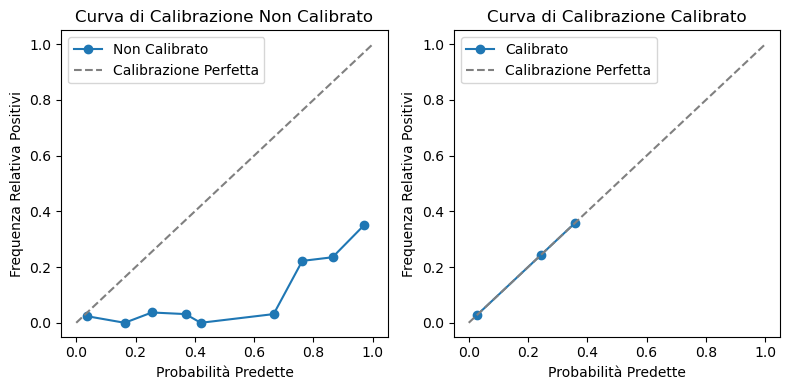

In [121]:
#CLASSIFICATION
cols = ['classname_presence', 'lastcolname_classmatch', 'classname_categorical',
        'date_counter','are_sorted_dates', 'silhouette']

cl_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_classifier(data, cols, 'classification', cl_model)

## Regression

Accuracy: 0.7455621301775148
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.73      0.83       292
           1       0.33      0.83      0.47        46

    accuracy                           0.75       338
   macro avg       0.65      0.78      0.65       338
weighted avg       0.88      0.75      0.78       338

Confusion Matrix:
 [[214  78]
 [  8  38]]


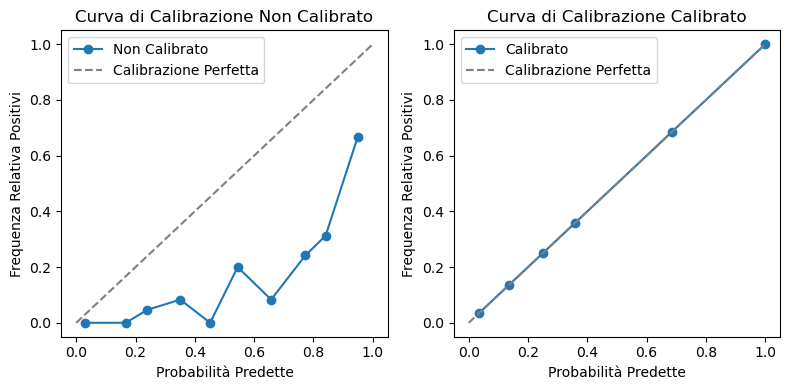

In [103]:
#REGRESSION
cols = ['numvariable_counter', 'numvariable_proportion', 
        'variablenormal_counter', 'variablenormal_proportion']

reg_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_classifier(data, cols, 'regression', reg_model)

## NLP

Accuracy: 0.8668639053254438
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       268
           1       0.64      0.80      0.71        70

    accuracy                           0.87       338
   macro avg       0.79      0.84      0.81       338
weighted avg       0.88      0.87      0.87       338

Confusion Matrix:
 [[237  31]
 [ 14  56]]


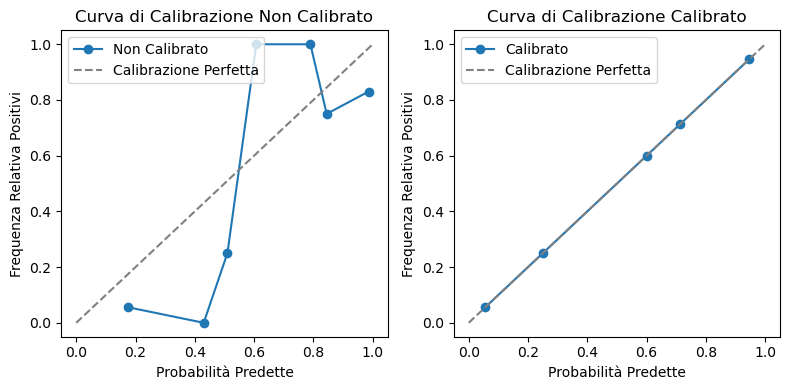

In [107]:
#NLP
cols = ['textual_variables_counter', 'textual_proportion']

nlp_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_classifier(data, cols, 'nlp', nlp_model)

## Clustering

Accuracy: 0.6124260355029586
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.54      0.69       276
           1       0.32      0.95      0.47        62

    accuracy                           0.61       338
   macro avg       0.65      0.74      0.58       338
weighted avg       0.86      0.61      0.65       338

Confusion Matrix:
 [[148 128]
 [  3  59]]


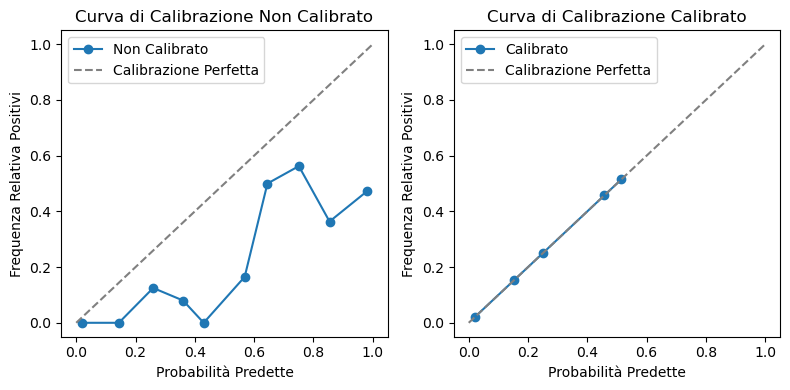

In [105]:
#CLUSTERING
cols = ['silhouette', 'date_counter','are_sorted_dates']

clu_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_classifier(data, cols, 'clustering', clu_model)

## Time Series

Accuracy: 0.757396449704142
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79       208
           1       0.66      0.75      0.70       130

    accuracy                           0.76       338
   macro avg       0.75      0.76      0.75       338
weighted avg       0.77      0.76      0.76       338

Confusion Matrix:
 [[159  49]
 [ 33  97]]


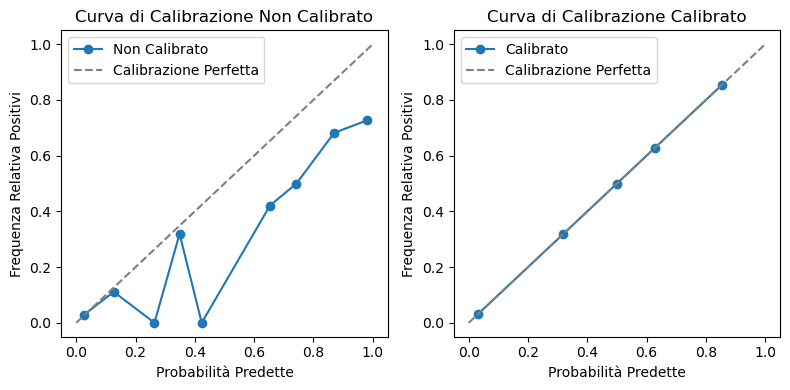

In [106]:
#TIME SERIES
cols = ['date_counter','are_sorted_dates', 'silhouette']

ts_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_classifier(data, cols, 'time_series', ts_model)

## PCA

In [108]:
#PCA
#cols = ['n_features', 'n_instances']
#pca_model = RandomForestClassifier(n_estimators=100, random_state=42)
#ml_classifier(data, cols, 'pca', pca_model)

In [110]:
def main(datapoints_path):  
    #Creazione Dataset 
    cols = ['dataset_name', #generic
            'n_features', #generic/pca
            'n_instances', #generic
            'title_match', #generic
            'classname_presence','lastcolname_classmatch', 'classname_categorical', #classification
            'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
            'textual_variables_counter', 'textual_proportion', #nlp
            'silhouette', #clustering
            'date_counter','are_sorted_dates', #time series
            'label']
    
    data = pd.DataFrame(columns=cols)
    datapoints = [datapoint for datapoint in os.listdir(datapoints_path)]
    for datapoint in datapoints:
        #print(datapoint)
        datapoint_path = datapoints_path +'/'+ datapoint
        json_datapoint = {}
        with open(datapoint_path, 'r') as file:
            json_datapoint = json.load(file)       
        for file in json_datapoint["files"]:
                #print(json_datapoint['_id'])
                #print(file['file_name'])
            if (file['file_type'] == 'tabular'):  
                #dataset title match with term:category itself
                filename_normalized = normalize_word(str(file['file_name']))
                title_match = 0
                #if(category in filename_normalized):
                #    title_match = 1

                result = get_properties(file['features_content'])  
                data.loc[len(data)] = [file['file_name'],
                                        file['n_features'], #all categories
                                        file['n_istances'], #all categories
                                        title_match, #all categories
                                        result[0],result[1],result[2], #classification
                                        result[3],result[4],result[5],result[6], #linear regression
                                        result[7], result[8], #nlp
                                        result[9],
                                        result[10],result[11],
                                        None] #label
                
                
    print(data)
    results = []
    
    X = data.loc[:, ['classname_presence', 'lastcolname_classmatch', 'classname_categorical']]
    results.append(cl_model.predict_proba(X)[:, 1])
    print(results)





In [109]:
#main('output_datasets')

In [ ]:
#ALTRO (TEST..)

In [ ]:
# Ottieni l'importanza delle features
importances = rf_model.feature_importances_

# Ottieni l'indice delle features ordinate per importanza
indices = np.argsort(importances)[::-1]

# Stampa l'importanza delle features in ordine
print("Importanza delle features:")
for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")

In [ ]:

logistic_model = LogisticRegression(random_state=0)

logistic_model.fit(X_train_down, y_train_down)

y_pred_logistic = logistic_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)

print(f'Accuracy (Logistic Regression): {accuracy_logistic}')
print("Classification Report (Logistic Regression):\n", report_logistic)
print("Confusion Matrix (Logistic Regression):\n", conf_matrix_logistic)

In [ ]:
from scipy.stats import shapiro, kstest
import numpy as np

datan = np.random.normal(size=100)  # Sostituisci con il tuo vettore di dati
datan = [1,2,3,np.nan]
stat_shapiro, p_shapiro = shapiro(datan)
stat_kstest, p_kstest = kstest(datan, 'norm')

print(f'Shapiro-Wilk Test: Statistica={stat_shapiro}, p-value={p_shapiro}')
print(f'Kolmogorov-Smirnov Test: Statistica={stat_kstest}, p-value={p_kstest}')

In [ ]:
[float(elemento) for elemento in ['3.4567','2',4]]